### Run basic `scanpy` QC and doublet detection with `scrublet` for **PBMC Tuberculosis** _Cai Y et al 2020_

**Objective**: Review QC process and suggest changes


- **Developed by**: Carlos Talavera-López PhD
- **Modified by**: Mairi McClean
- **Computational Health Centre - Helmholtz Munich**
- v221116

### Load required modules

In [1]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scrublet as scr
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.2.0
appnope             0.1.3
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
colorama            0.4.6
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.3
decorator           5.1.1
entrypoints         0.4
executing           1.1.1
h5py                3.6.0
hypergeom_ufunc     NA
ipykernel           6.16.2
jedi                0.18.1
joblib              1.2.0
kiwisolver          1.4.4
llvmlite            0.39.1
matplotlib          3.6.1
mpl_toolkits        NA
natsort             8.2.0
nbinom_ufunc        NA
ncf_ufunc           NA
numba               0.56.3
numexpr             2.8.1
numpy               1.23.4
packaging           21.3
pandas              1.5.1
parso               0.8.3
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit      3.0.31
psutil      

### Read datasets

In [3]:
adata = sc.read_h5ad('/Users/mairi.mcclean/github/data/tb_pbmc_datasets/CaiY2022_TB.raw.h5ad')
adata

AnnData object with n_obs × n_vars = 223089 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'data_type', 'centre', 'version', 'object', 'protocol'
    var: 'gene_name'

In [4]:
adata.var

gene_name
gene_id                       
ENSG00000223972.5      DDX11L1
ENSG00000227232.5       WASH7P
ENSG00000278267.1    MIR6859-1
ENSG00000243485.5  MIR1302-2HG
ENSG00000284332.1    MIR1302-2
...                        ...
ENSG00000198695.2       MT-ND6
ENSG00000210194.1        MT-TE
ENSG00000198727.2       MT-CYB
ENSG00000210195.2        MT-TT
ENSG00000210196.2        MT-TP

[61533 rows x 1 columns]

In [6]:
# checks the number of molecules counted per barcode(?), using "donor" as proxy(?)
adata.obs['donor'].value_counts()

P3    93079
P1    37811
P4    34720
P2    26189
P5    20644
P6    10646
Name: donor, dtype: int64

In [7]:
adata.obs['data_type'].values

['scRNAseq', 'scRNAseq', 'scRNAseq', 'scRNAseq', 'scRNAseq', ..., 'scTCRseq', 'scTCRseq', 'scTCRseq', 'scTCRseq', 'scTCRseq']
Length: 223089
Categories (2, object): ['scRNAseq', 'scTCRseq']

Does this not mean that only scRNAseq data was included?

In [8]:
adata.var_names_make_unique()
sample_object = adata.copy()
sample_object

AnnData object with n_obs × n_vars = 223089 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'data_type', 'centre', 'version', 'object', 'protocol'
    var: 'gene_name'

### Replace gene symbols 

#### Performed to ensure that concatenation of the indexes is smoother

In [9]:
sample_object.var['gene_id'] = sample_object.var.index.copy()
sample_object.var.set_index('gene_name', inplace = True)
sample_object.var.head()

gene_id
gene_name                     
DDX11L1      ENSG00000223972.5
WASH7P       ENSG00000227232.5
MIR6859-1    ENSG00000278267.1
MIR1302-2HG  ENSG00000243485.5
MIR1302-2    ENSG00000284332.1

In [10]:
sample_object.var_names = [str(i) for i in sample_object.var_names]
sample_object.var_names_make_unique()


/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


### Inital scatterplot of top 20

normalizing counts per cell


/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


    finished (0:00:00)


/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


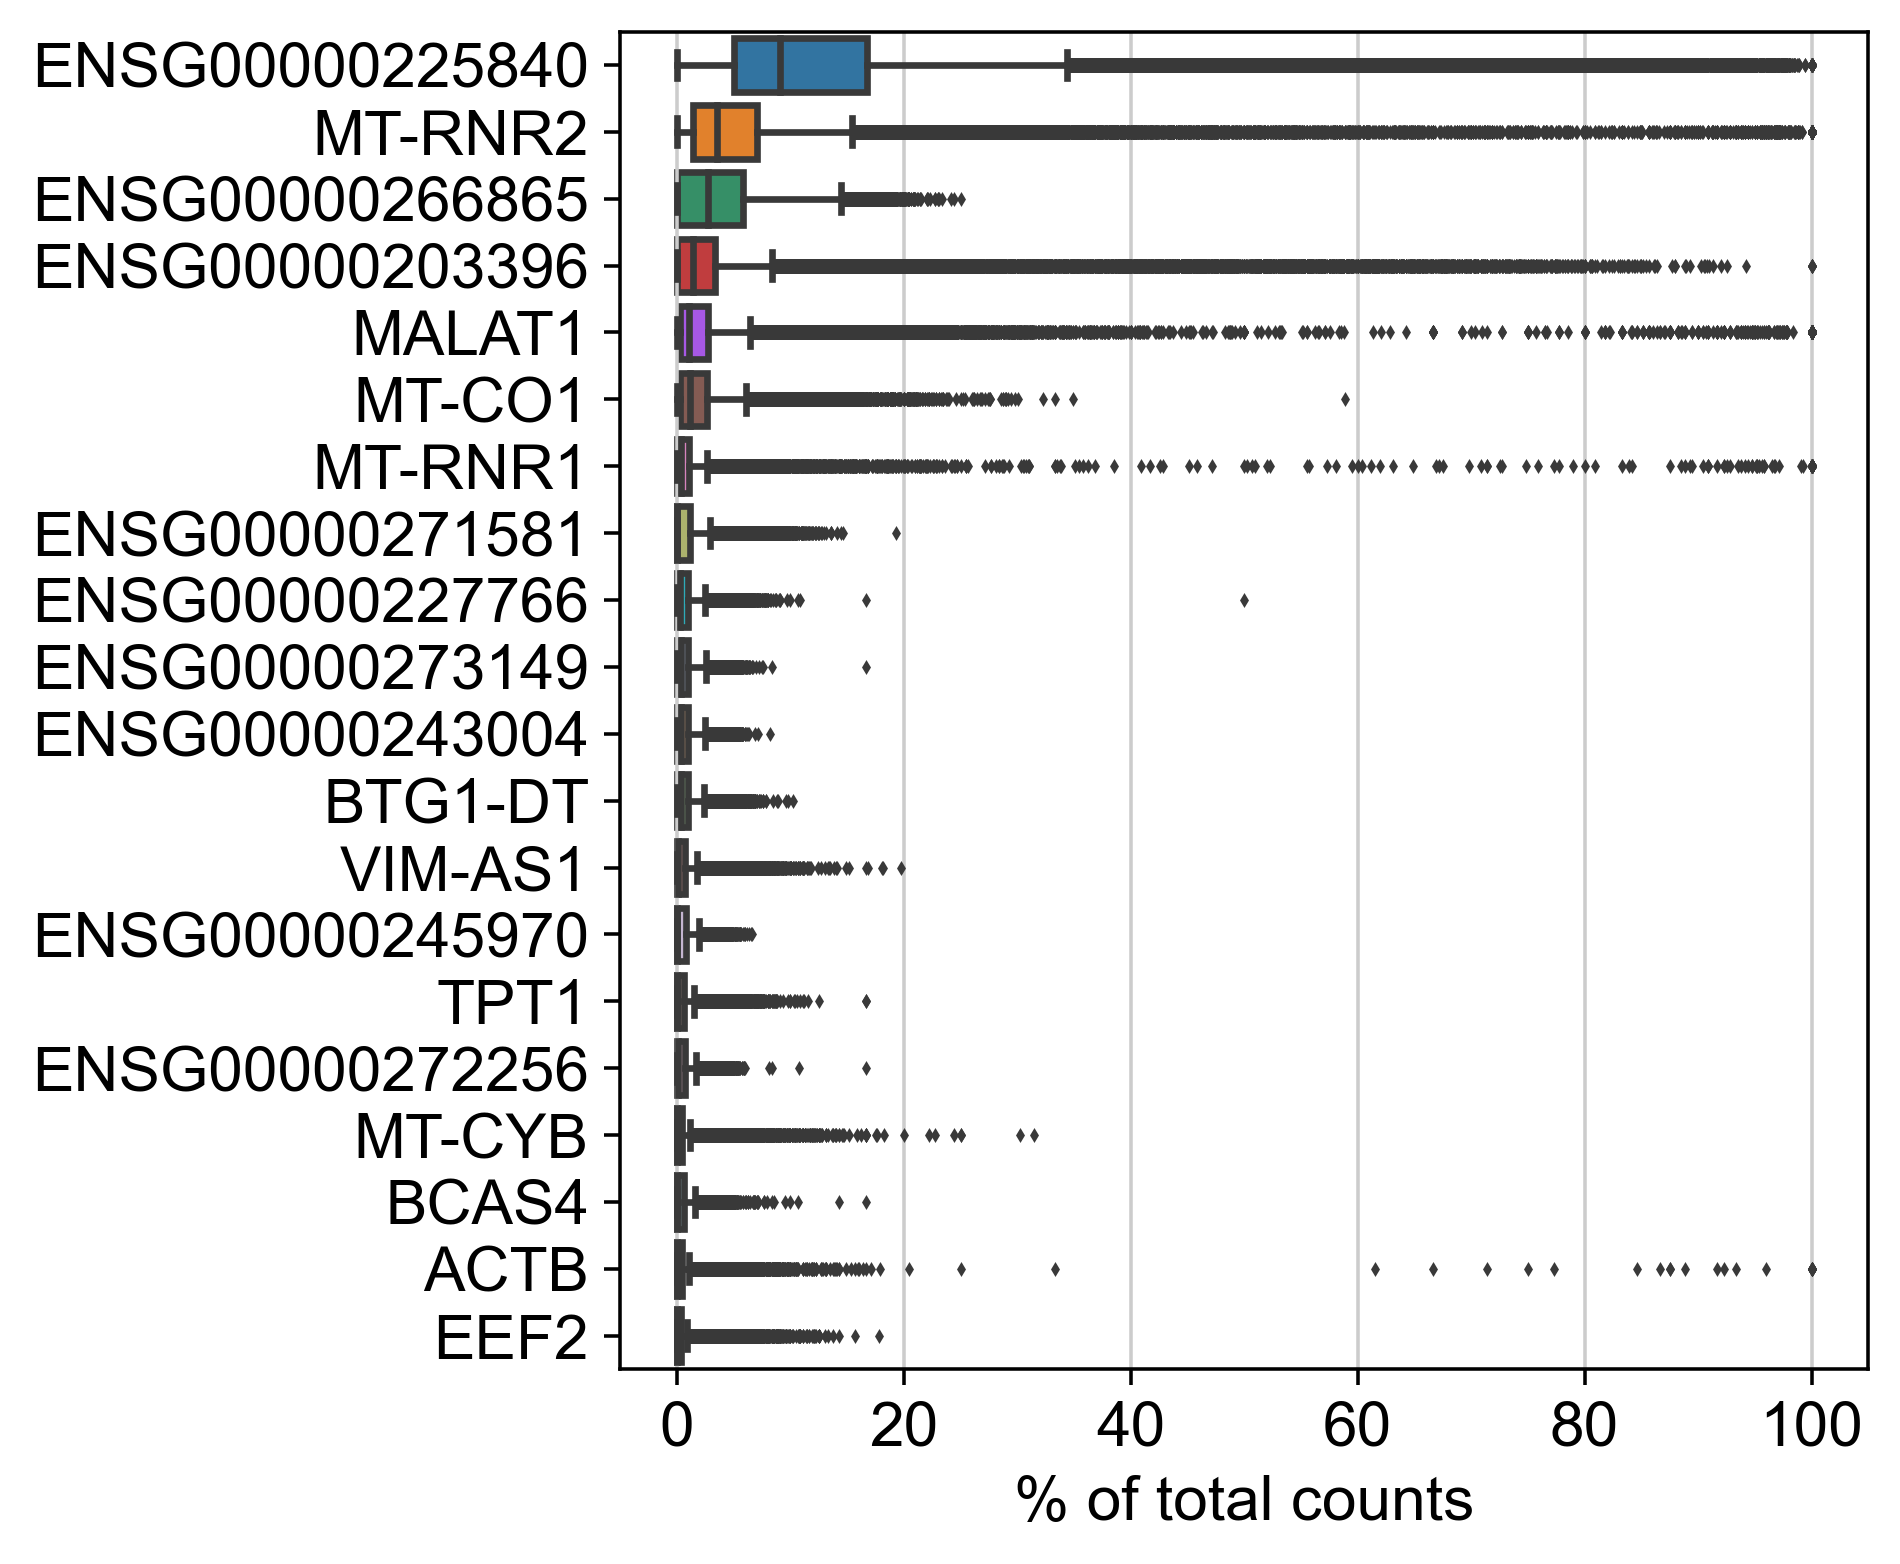

In [11]:
# highest fraction of counts per cell

sc.pl.highest_expr_genes(sample_object, n_top=20)

### Filter cells with less than 200 genes

In [12]:
sc.pp.filter_cells(sample_object, min_genes = 200)
print(sample_object.n_obs, sample_object.n_vars)

filtered out 150854 cells that have less than 200 genes expressed
72235 61533


In [13]:
sample_object.shape

(72235, 61533)

In [14]:
sample_object.var

gene_id
DDX11L1      ENSG00000223972.5
WASH7P       ENSG00000227232.5
MIR6859-1    ENSG00000278267.1
MIR1302-2HG  ENSG00000243485.5
MIR1302-2    ENSG00000284332.1
...                        ...
MT-ND6       ENSG00000198695.2
MT-TE        ENSG00000210194.1
MT-CYB       ENSG00000198727.2
MT-TT        ENSG00000210195.2
MT-TP        ENSG00000210196.2

[61533 rows x 1 columns]

### Filter genes in less than 5 cells


In [15]:
# Parameters (cells=3) taken from scanpy tutorial; others say 5? Will revisit
sc.pp.filter_genes(sample_object, min_cells=3)

filtered out 26143 genes that are detected in less than 3 cells


### Remove all data that is not scRNAseq

In [33]:
sample_object.obs

study individual     sample  \
barcode                                                                     
AAACCTGGTATAGGGC-HRS180101-pbmc_scRNAseq  CaiY_2022  HRI111687  HRS180101   
AAACCTGTCTTTAGTC-HRS180101-pbmc_scRNAseq  CaiY_2022  HRI111687  HRS180101   
AAACGGGAGTTAACGA-HRS180101-pbmc_scRNAseq  CaiY_2022  HRI111687  HRS180101   
AAAGATGAGCAGACTG-HRS180101-pbmc_scRNAseq  CaiY_2022  HRI111687  HRS180101   
AAAGATGAGGACGAAA-HRS180101-pbmc_scRNAseq  CaiY_2022  HRI111687  HRS180101   
...                                             ...        ...        ...   
TTTGTCAAGTGTTAGA-HRS100514-pfmc_scTCRseq  CaiY_2022  HRI068293  HRS100514   
TTTGTCACATCTACGA-HRS100514-pfmc_scTCRseq  CaiY_2022  HRI068293  HRS100514   
TTTGTCATCTAACTCT-HRS100514-pfmc_scTCRseq  CaiY_2022  HRI068293  HRS100514   
TTTGTCATCTCGTTTA-HRS100514-pfmc_scTCRseq  CaiY_2022  HRI068293  HRS100514   
TTTGTCATCTTGTCAT-HRS100514-pfmc_scTCRseq  CaiY_2022  HRI068293  HRS100514   

                                         tissue donor data_type  \
barcode                                                           
AAACCTGGTATAGGGC-HRS180101-pbmc_scRNAseq   PBMC    P5  scRNAseq   
AAACCTGTCTTTAGTC-HRS180101-pbmc_scRNAseq   PBMC    P5  scRNAseq   
AAACGGGAGTTAACGA-HRS180101-pbmc_scRNAseq   PBMC    P5  scRNAseq   
AAAGATGAGCAGACTG-HRS180101-pbmc_scRNAseq   PBMC    P5  scRNAseq   
AAAGATGAGGACGAAA-HRS180101-pbmc_scRNAseq   PBMC    P5  scRNAseq   
...                                         ...   ...       ...   
TTTGTCAAGTGTTAGA-HRS100514-pfmc_scTCRseq   PFMC    P4  scTCRseq   
TTTGTCACATCTACGA-HRS100514-pfmc_scTCRseq   PFMC    P4  scTCRseq   
TTTGTCATCTAACTCT-HRS100514-pfmc_scTCRseq   PFMC    P4  scTCRseq   
TTTGTCATCTCGTTTA-HRS100514-pfmc_scTCRseq   PFMC    P4  scTCRseq   
TTTGTCATCTTGTCAT-HRS100514-pfmc_scTCRseq   PFMC    P4  scTCRseq   

                                                       centre version  \
barcode                                                                 
AAACCTGGTATAGGGC-HRS180101-pbmc_scRNAseq  Shenzhen University   10XV2   
AAACCTGTCTTTAGTC-HRS180101-pbmc_scRNAseq  Shenzhen University   10XV2   
AAACGGGAGTTAACGA-HRS180101-pbmc_scRNAseq  Shenzhen University   10XV2   
AAAGATGAGCAGACTG-HRS180101-pbmc_scRNAseq  Shenzhen University   10XV2   
AAAGATGAGGACGAAA-HRS180101-pbmc_scRNAseq  Shenzhen University   10XV2   
...                                                       ...     ...   
TTTGTCAAGTGTTAGA-HRS100514-pfmc_scTCRseq  Shenzhen University   10XV2   
TTTGTCACATCTACGA-HRS100514-pfmc_scTCRseq  Shenzhen University   10XV2   
TTTGTCATCTAACTCT-HRS100514-pfmc_scTCRseq  Shenzhen University   10XV2   
TTTGTCATCTCGTTTA-HRS100514-pfmc_scTCRseq  Shenzhen University   10XV2   
TTTGTCATCTTGTCAT-HRS100514-pfmc_scTCRseq  Shenzhen University   10XV2   

                                             object       protocol  n_genes  \
barcode                                                                       
AAACCTGGTATAGGGC-HRS180101-pbmc_scRNAseq  HRS180101  pbmc_scRNAseq      213   
AAACCTGTCTTTAGTC-HRS180101-pbmc_scRNAseq  HRS180101  pbmc_scRNAseq      206   
AAACGGGAGTTAACGA-HRS180101-pbmc_scRNAseq  HRS180101  pbmc_scRNAseq      201   
AAAGATGAGCAGACTG-HRS180101-pbmc_scRNAseq  HRS180101  pbmc_scRNAseq      237   
AAAGATGAGGACGAAA-HRS180101-pbmc_scRNAseq  HRS180101  pbmc_scRNAseq      255   
...                                             ...            ...      ...   
TTTGTCAAGTGTTAGA-HRS100514-pfmc_scTCRseq  HRS100514  pfmc_scTCRseq      233   
TTTGTCACATCTACGA-HRS100514-pfmc_scTCRseq  HRS100514  pfmc_scTCRseq      264   
TTTGTCATCTAACTCT-HRS100514-pfmc_scTCRseq  HRS100514  pfmc_scTCRseq      271   
TTTGTCATCTCGTTTA-HRS100514-pfmc_scTCRseq  HRS100514  pfmc_scTCRseq      522   
TTTGTCATCTTGTCAT-HRS100514-pfmc_scTCRseq  HRS100514  pfmc_scTCRseq      274   

                                          n_genes_by_counts  total_counts  \
barcode                                                                     
AAACCTGGTATAGGGC-HRS180101-pbmc_scRNAseq

In [34]:
sample_object.obs['data_type']

barcode
AAACCTGGTATAGGGC-HRS180101-pbmc_scRNAseq    scRNAseq
AAACCTGTCTTTAGTC-HRS180101-pbmc_scRNAseq    scRNAseq
AAACGGGAGTTAACGA-HRS180101-pbmc_scRNAseq    scRNAseq
AAAGATGAGCAGACTG-HRS180101-pbmc_scRNAseq    scRNAseq
AAAGATGAGGACGAAA-HRS180101-pbmc_scRNAseq    scRNAseq
                                              ...   
TTTGTCAAGTGTTAGA-HRS100514-pfmc_scTCRseq    scTCRseq
TTTGTCACATCTACGA-HRS100514-pfmc_scTCRseq    scTCRseq
TTTGTCATCTAACTCT-HRS100514-pfmc_scTCRseq    scTCRseq
TTTGTCATCTCGTTTA-HRS100514-pfmc_scTCRseq    scTCRseq
TTTGTCATCTTGTCAT-HRS100514-pfmc_scTCRseq    scTCRseq
Name: data_type, Length: 72235, dtype: category
Categories (2, object): ['scRNAseq', 'scTCRseq']

In [38]:
sample_object.obs['data_type'].cat.categories

Index(['scRNAseq', 'scTCRseq'], dtype='object')

In [43]:
# Code from https://scanpy.discourse.group/t/filter-out-specific-clusters-using-their-cluster-number/82

sample_object_new = sample_object[~sample_object.obs['data_type'].isin(['scTCRseq']),:]

In [44]:
sample_object_new

View of AnnData object with n_obs × n_vars = 66560 × 35390
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'data_type', 'centre', 'version', 'object', 'protocol', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts'
    var: 'gene_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'
    uns: 'donor_colors'

In [46]:
sample_object_new.obs['data_type'].cat.categories

Index(['scRNAseq'], dtype='object')

### Compute QC stats

#### Remove mt genes

In [47]:
sample_object_new.shape

(66560, 35390)

In [48]:
sample_object_new.var['mt'] = sample_object_new.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(sample_object_new, qc_vars = ['mt'], percent_top = None, log1p = False, inplace = True)
sample_object_new.var

/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_59214/2569733444.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  sample_object_new.var['mt'] = sample_object_new.var_names.str.startswith('MT-')


gene_id  n_cells     mt  n_cells_by_counts  \
DDX11L1          ENSG00000223972.5        9  False                  8   
WASH7P           ENSG00000227232.5       41  False                 39   
OR4G11P          ENSG00000240361.2        4  False                  4   
OR4F5            ENSG00000186092.7        6  False                  6   
ENSG00000238009  ENSG00000238009.6       54  False                 54   
...                            ...      ...    ...                ...   
MT-ND6           ENSG00000198695.2    32012   True              31515   
MT-TE            ENSG00000210194.1     1062   True               1054   
MT-CYB           ENSG00000198727.2    43682   True              39751   
MT-TT            ENSG00000210195.2       84   True                 77   
MT-TP            ENSG00000210196.2     5329   True               5287   

                 mean_counts  pct_dropout_by_counts  total_counts   ribo  
DDX11L1             0.000135              99.987981           9.0  False  
WASH7P              0.000586              99.941406          39.0  False  
OR4G11P             0.000075              99.993990           5.0  False  
OR4F5               0.000090              99.990986           6.0  False  
ENSG00000238009     0.000826              99.918870          55.0  False  
...                      ...                    ...           ...    ...  
MT-ND6              0.827644              52.651743       55088.0  False  
MT-TE               0.017278              98.416466        1150.0  False  
MT-CYB              2.017383              40.277945      134277.0  False  
MT-TT               0.001157              99.884315          77.0  False  
MT-TP               0.088582              92.056791        5896.0  False  

[35390 rows x 8 columns]

#### Remove ribosomal RNA

###### When would you not remove ribosomal RNA?

In [18]:
sample_object_new.var['ribo'] = sample_object_new.var_names.str.startswith(("RPS","RPL"))
sc.pp.calculate_qc_metrics(sample_object_new, qc_vars = ['ribo'], percent_top = None, log1p = False, inplace = True)
sample_object_new.var

gene_id  n_cells     mt  n_cells_by_counts  \
DDX11L1          ENSG00000223972.5        9  False                  9   
WASH7P           ENSG00000227232.5       41  False                 41   
OR4G11P          ENSG00000240361.2        4  False                  4   
OR4F5            ENSG00000186092.7        6  False                  6   
ENSG00000238009  ENSG00000238009.6       54  False                 54   
...                            ...      ...    ...                ...   
MT-ND6           ENSG00000198695.2    32012   True              32012   
MT-TE            ENSG00000210194.1     1062   True               1062   
MT-CYB           ENSG00000198727.2    43682   True              43682   
MT-TT            ENSG00000210195.2       84   True                 84   
MT-TP            ENSG00000210196.2     5329   True               5329   

                 mean_counts  pct_dropout_by_counts  total_counts   ribo  
DDX11L1             0.000138              99.987541          10.0  False  
WASH7P              0.000568              99.943241          41.0  False  
OR4G11P             0.000069              99.994463           5.0  False  
OR4F5               0.000083              99.991694           6.0  False  
ENSG00000238009     0.000761              99.925244          55.0  False  
...                      ...                    ...           ...    ...  
MT-ND6              0.770444              55.683533       55653.0  False  
MT-TE               0.016031              98.529799        1158.0  False  
MT-CYB              2.059542              39.527930      148771.0  False  
MT-TT               0.001163              99.883713          84.0  False  
MT-TP               0.082204              92.622690        5938.0  False  

[35390 rows x 8 columns]

In [19]:
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
# add the total counts per cell as observations-annotation to adata

mito_genes = sample_object_new.var_names.str.startswith('MT-')
sample_object_new.obs['percent_mt2'] = np.sum(
    sample_object_new[:, mito_genes].X, axis = 1).A1 / np.sum(sample_object_new.X, axis = 1).A1
sample_object_new.obs['n_counts'] = sample_object_new.X.sum(axis = 1).A1

In [20]:
sample_object_new

AnnData object with n_obs × n_vars = 72235 × 35390
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'data_type', 'centre', 'version', 'object', 'protocol', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts'
    var: 'gene_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'

### Visualise QC metrics


In [21]:
sample_object_new.var_names

Index(['DDX11L1', 'WASH7P', 'OR4G11P', 'OR4F5', 'ENSG00000238009', 'CICP27',
       'ENSG00000268903', 'ENSG00000241860', 'ENSG00000241599', 'WASH9P',
       ...
       'MT-ND4', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-ND5', 'MT-ND6', 'MT-TE',
       'MT-CYB', 'MT-TT', 'MT-TP'],
      dtype='object', length=35390)

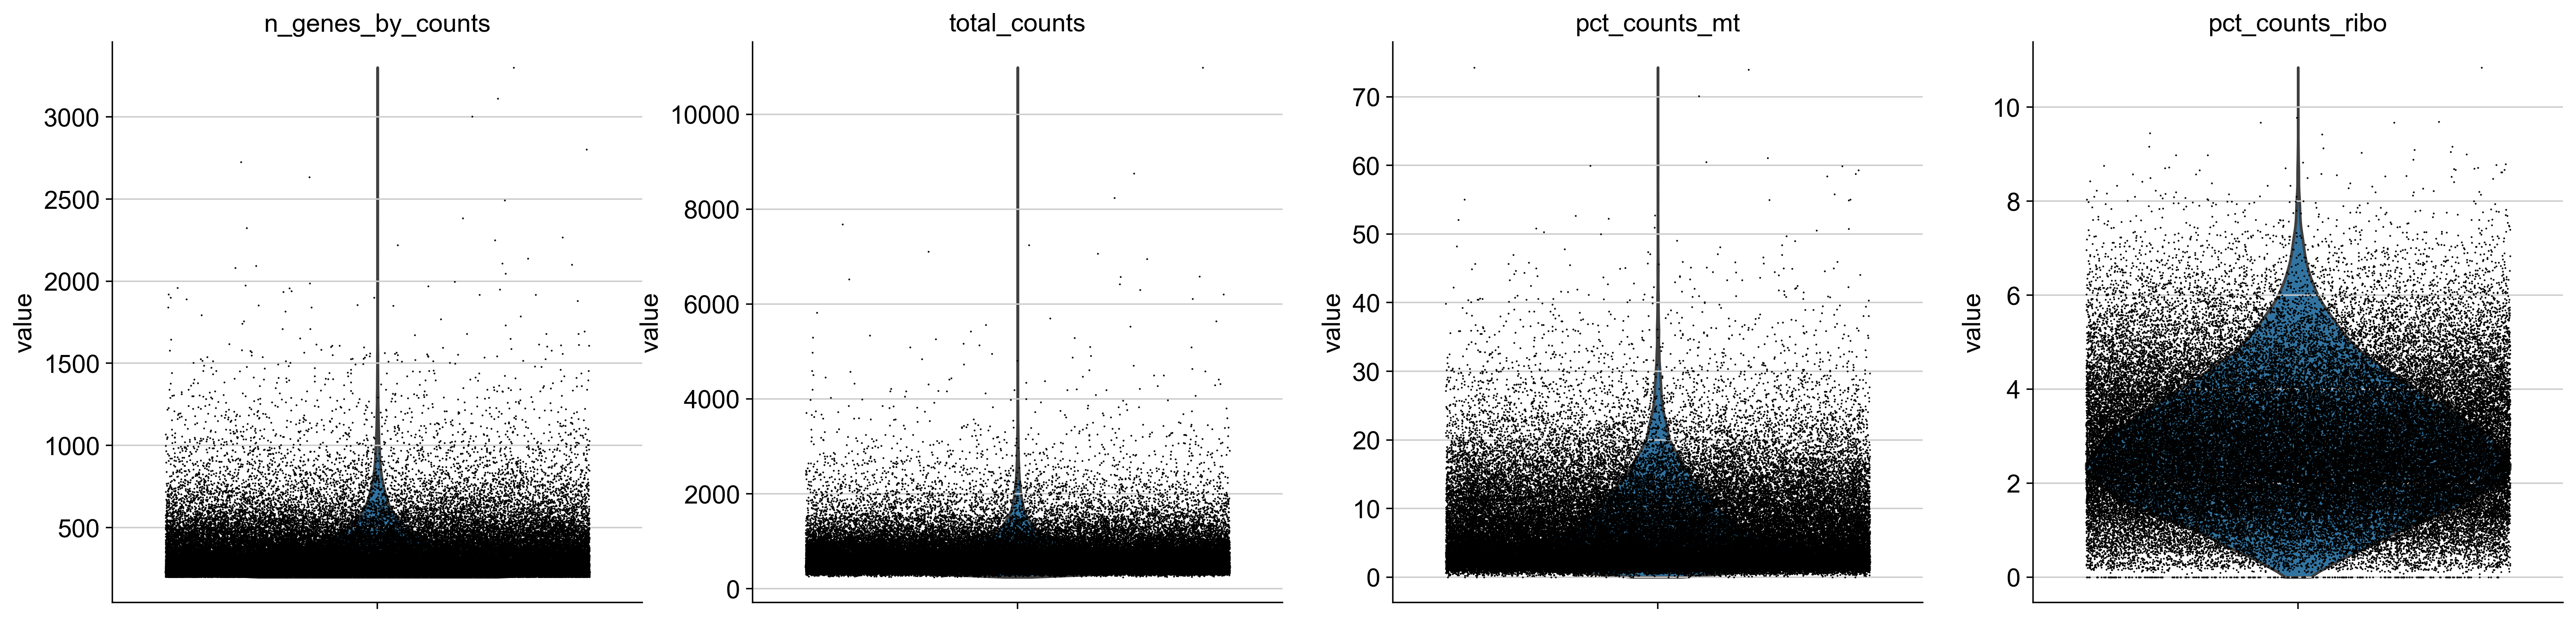

In [22]:
sc.pl.violin(sample_object_new, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

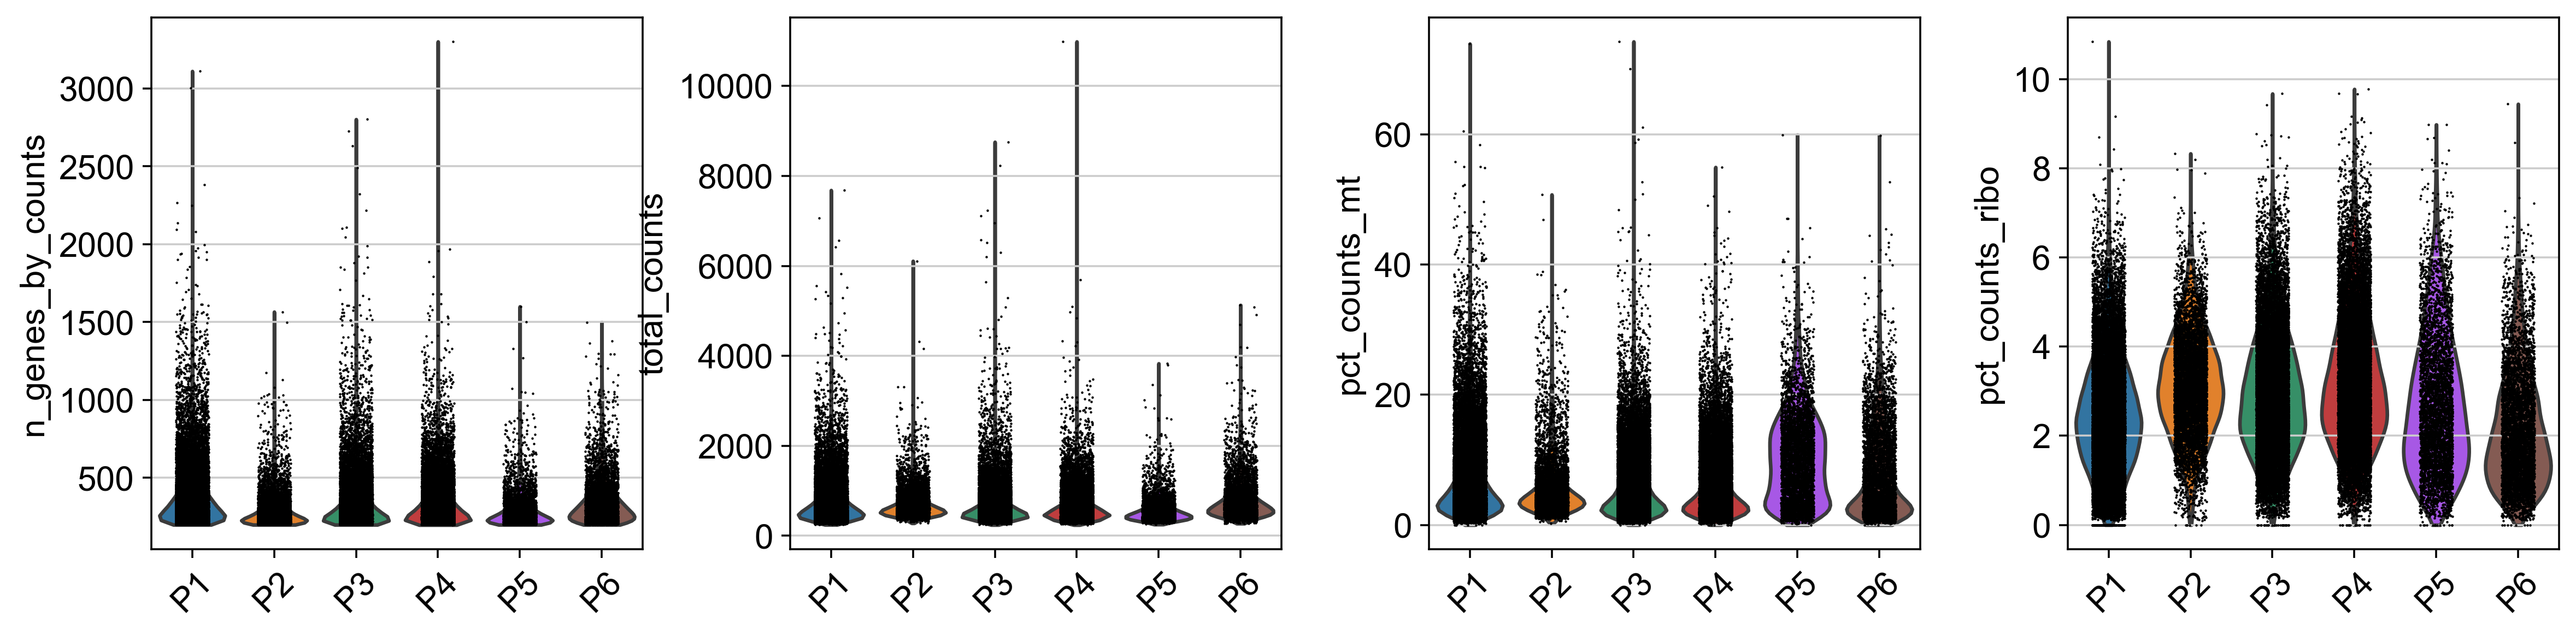

In [23]:
sc.pl.violin(sample_object_new, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter = 0.2, groupby = 'donor', rotation = 45)

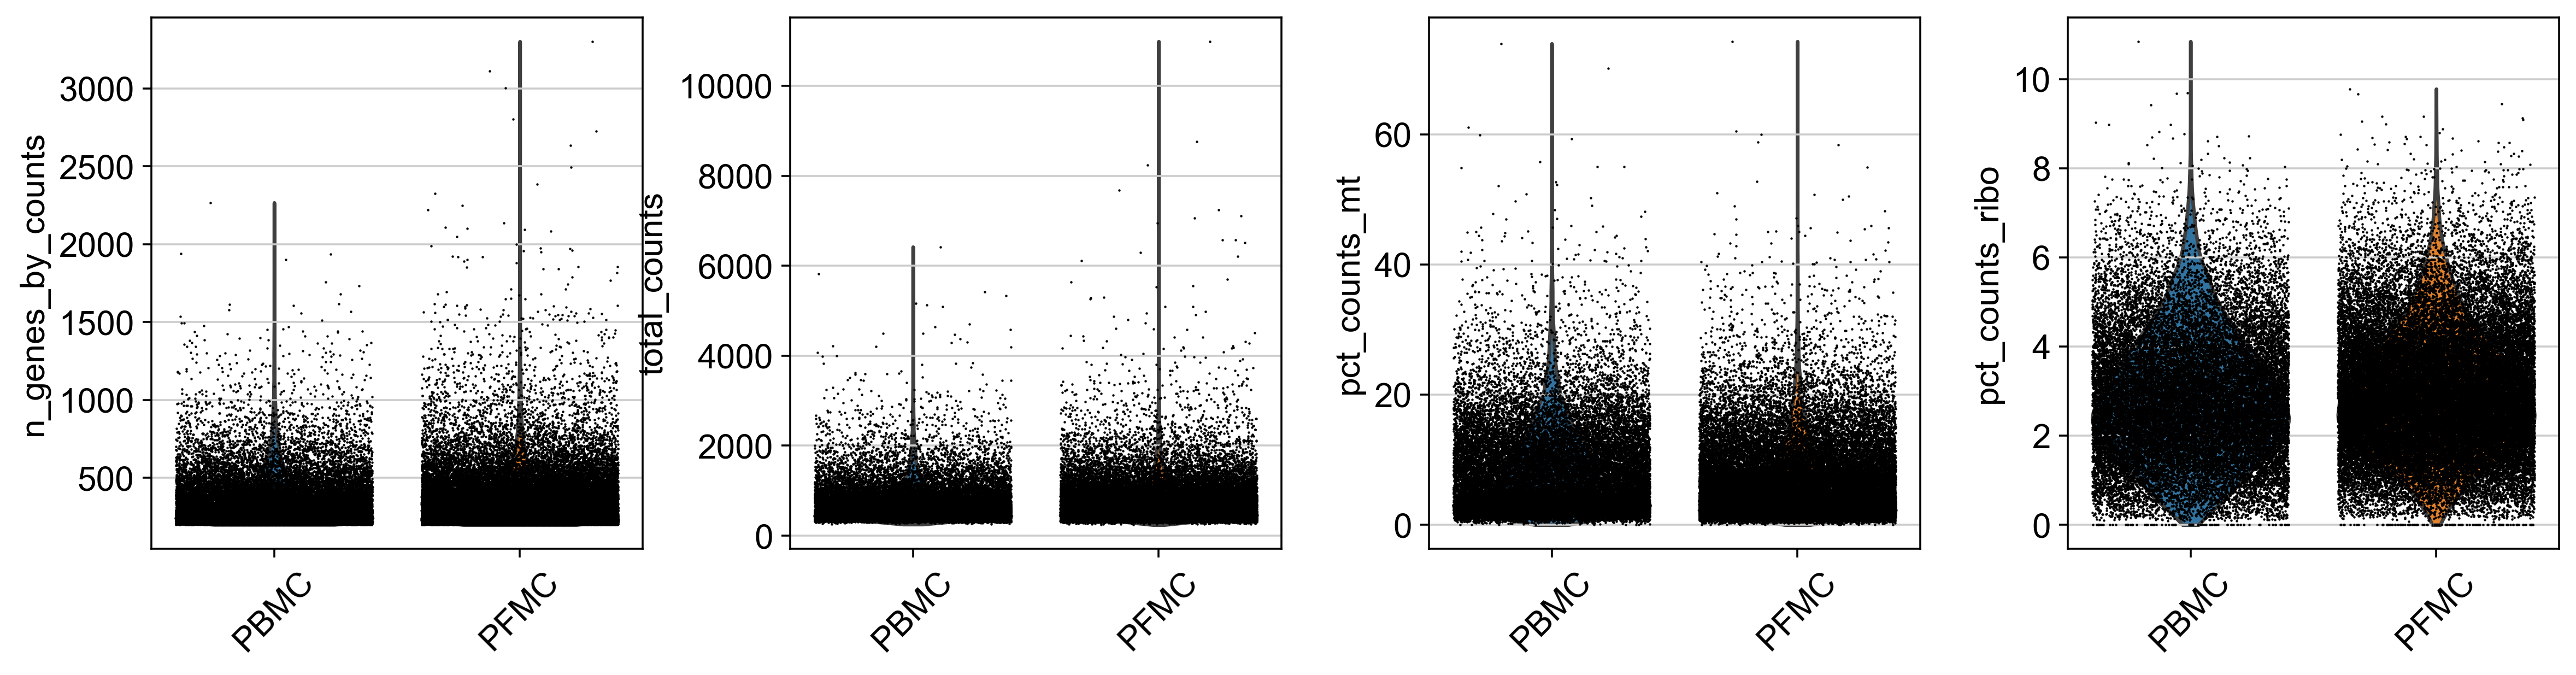

In [51]:
sc.pl.violin(sample_object_new, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter=0.4, groupby = 'tissue', rotation = 45)

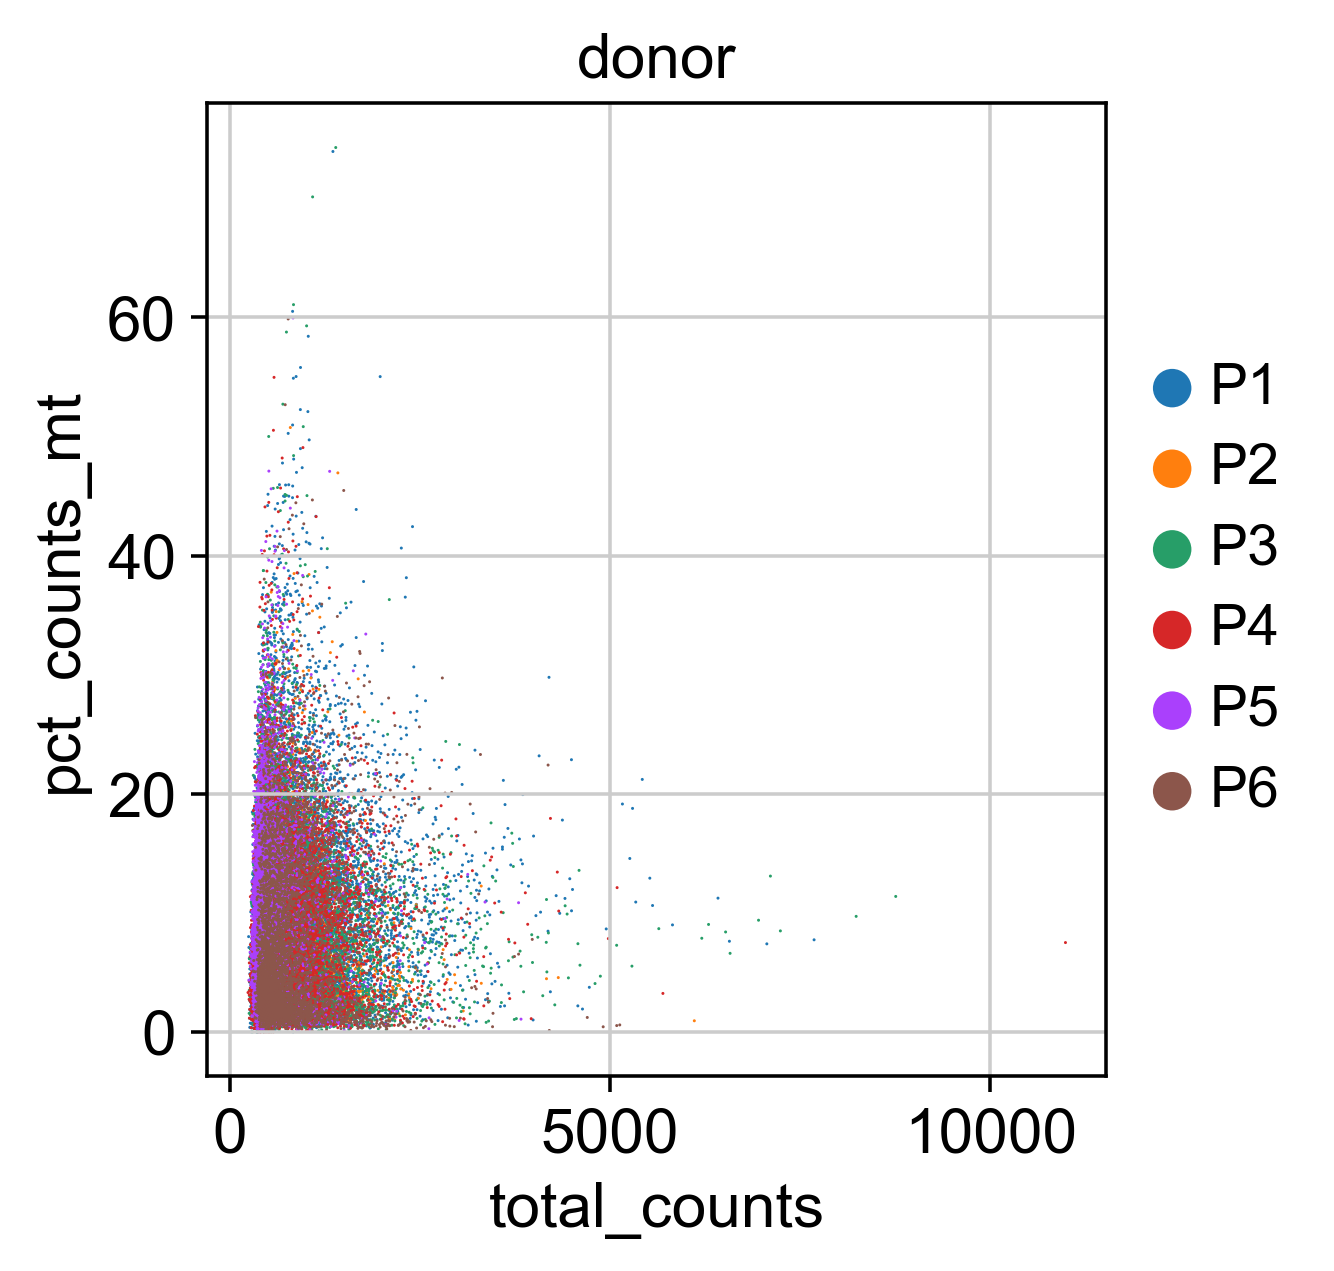

In [52]:
sc.pl.scatter(sample_object_new, x = 'total_counts', y = 'pct_counts_mt', color = "donor")

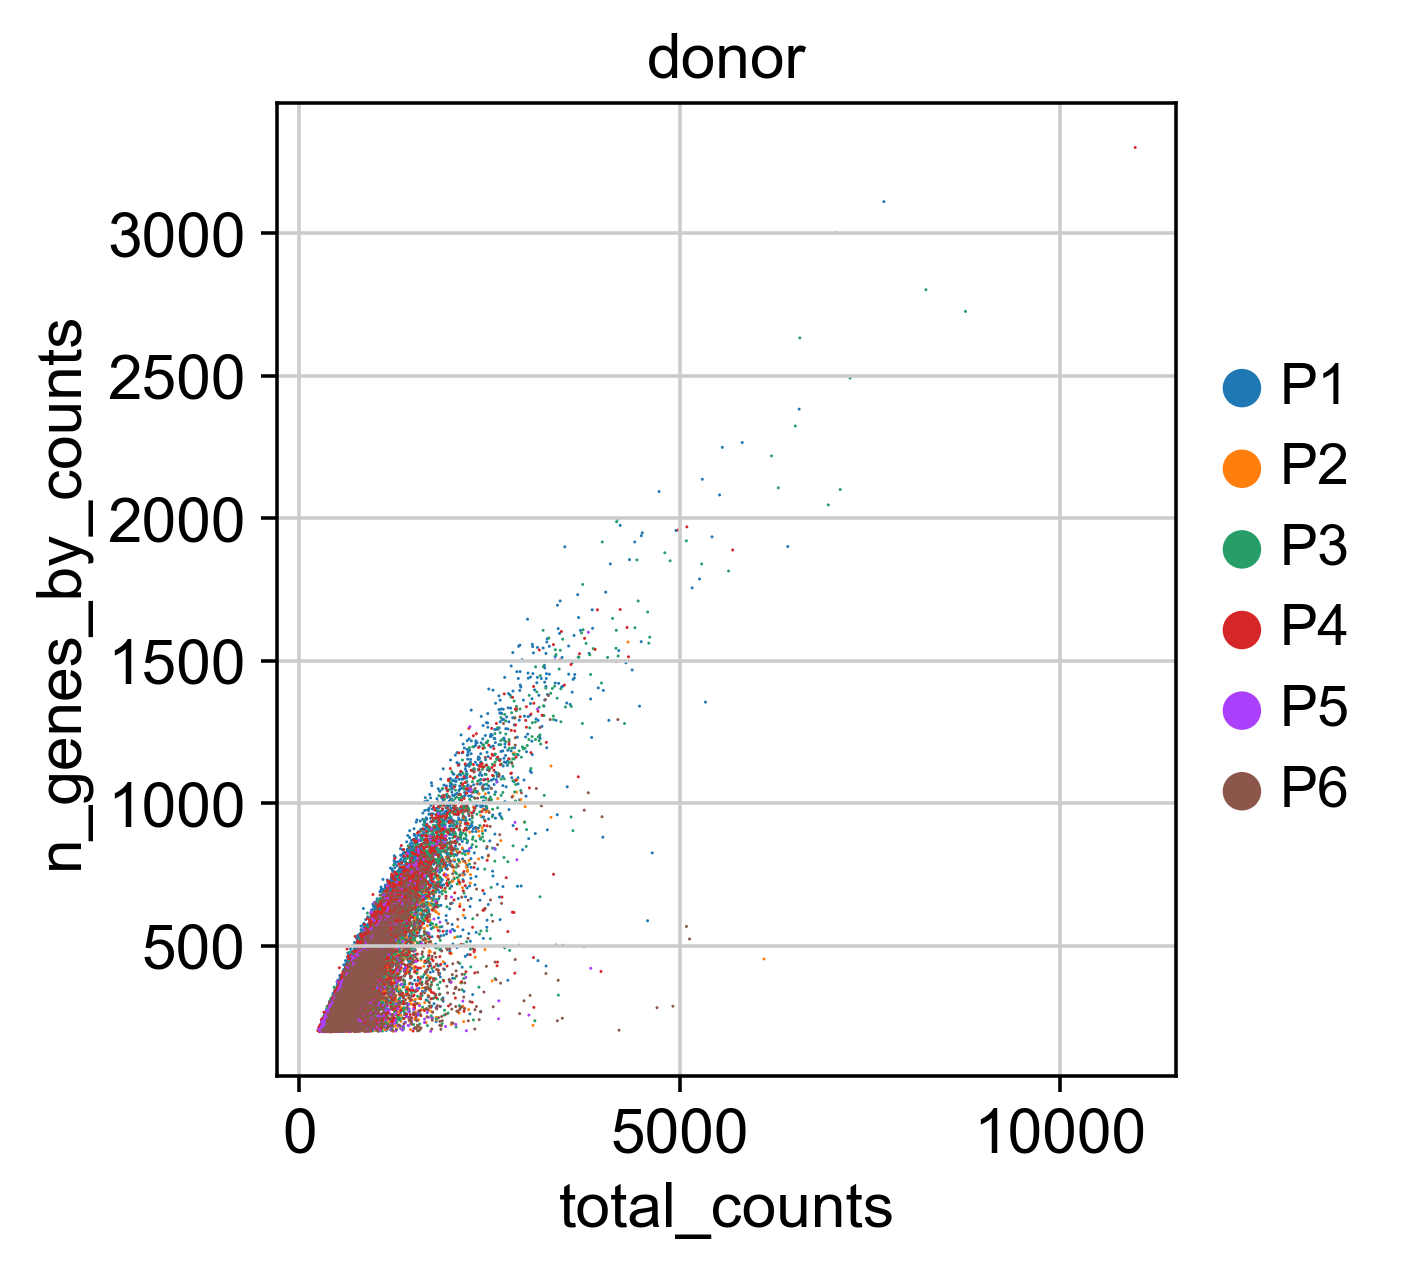

In [53]:
sc.pl.scatter(sample_object_new, x='total_counts', y='n_genes_by_counts', color = "donor")

### Filtering step

##### Values taken from Scanpy tutorial [https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html]

In [54]:
sample_object_new = sample_object_new[sample_object_new.obs.n_genes_by_counts < 2500, :]
sample_object_new = sample_object_new[sample_object_new.obs.pct_counts_mt < 5, :]

### Add sample sex covariate

In [55]:
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("external_gene_name")

In [56]:
annot.head()

ensembl_gene_id  start_position  end_position  \
external_gene_name                                                  
MT-TF               ENSG00000210049             577           647   
MT-RNR1             ENSG00000211459             648          1601   
MT-TV               ENSG00000210077            1602          1670   
MT-RNR2             ENSG00000210082            1671          3229   
MT-TL1              ENSG00000209082            3230          3304   

                   chromosome_name  
external_gene_name                  
MT-TF                           MT  
MT-RNR1                         MT  
MT-TV                           MT  
MT-RNR2                         MT  
MT-TL1                          MT

In [57]:
chrY_genes = sample_object_new.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

Index(['Y_RNA', 'XGY2', 'RPS4Y1', 'HSFY3P', 'ZFY', 'ZFY-AS1', 'EEF1A1P41',
       'LINC00278', 'PCDH11Y', 'FAM197Y9', 'PRKY', 'RN7SKP282', 'RFTN1P1',
       'ZNF736P9Y', 'LINC00279', 'USP9YP4', 'FAM197Y7', 'RBMY2QP', 'SNX18P1Y',
       'GYG2P1', 'RN7SL702P', 'USP9Y', 'CDY4P', 'DDX3Y', 'CASKP1', 'DPPA2P1',
       'UTY', 'PSMA6P1', 'TMSB4Y', 'ANOS2P', 'NLGN4Y', 'NLGN4Y-AS1', 'TTTY14',
       'ZNF839P1', 'BCORP1', 'TXLNGY', 'KDM5D', 'TTTY10', 'EIF1AY', 'HSFY4P',
       'PRORY', 'USP9YP3', 'RBMY2FP', 'PARP4P1'],
      dtype='object')

In [58]:
sample_object_new.obs['percent_chrY'] = np.sum(
    sample_object_new[:, chrY_genes].X, axis = 1).A1 / np.sum(sample_object_new.X, axis = 1).A1 * 100

/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_59214/3212827453.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sample_object_new.obs['percent_chrY'] = np.sum(


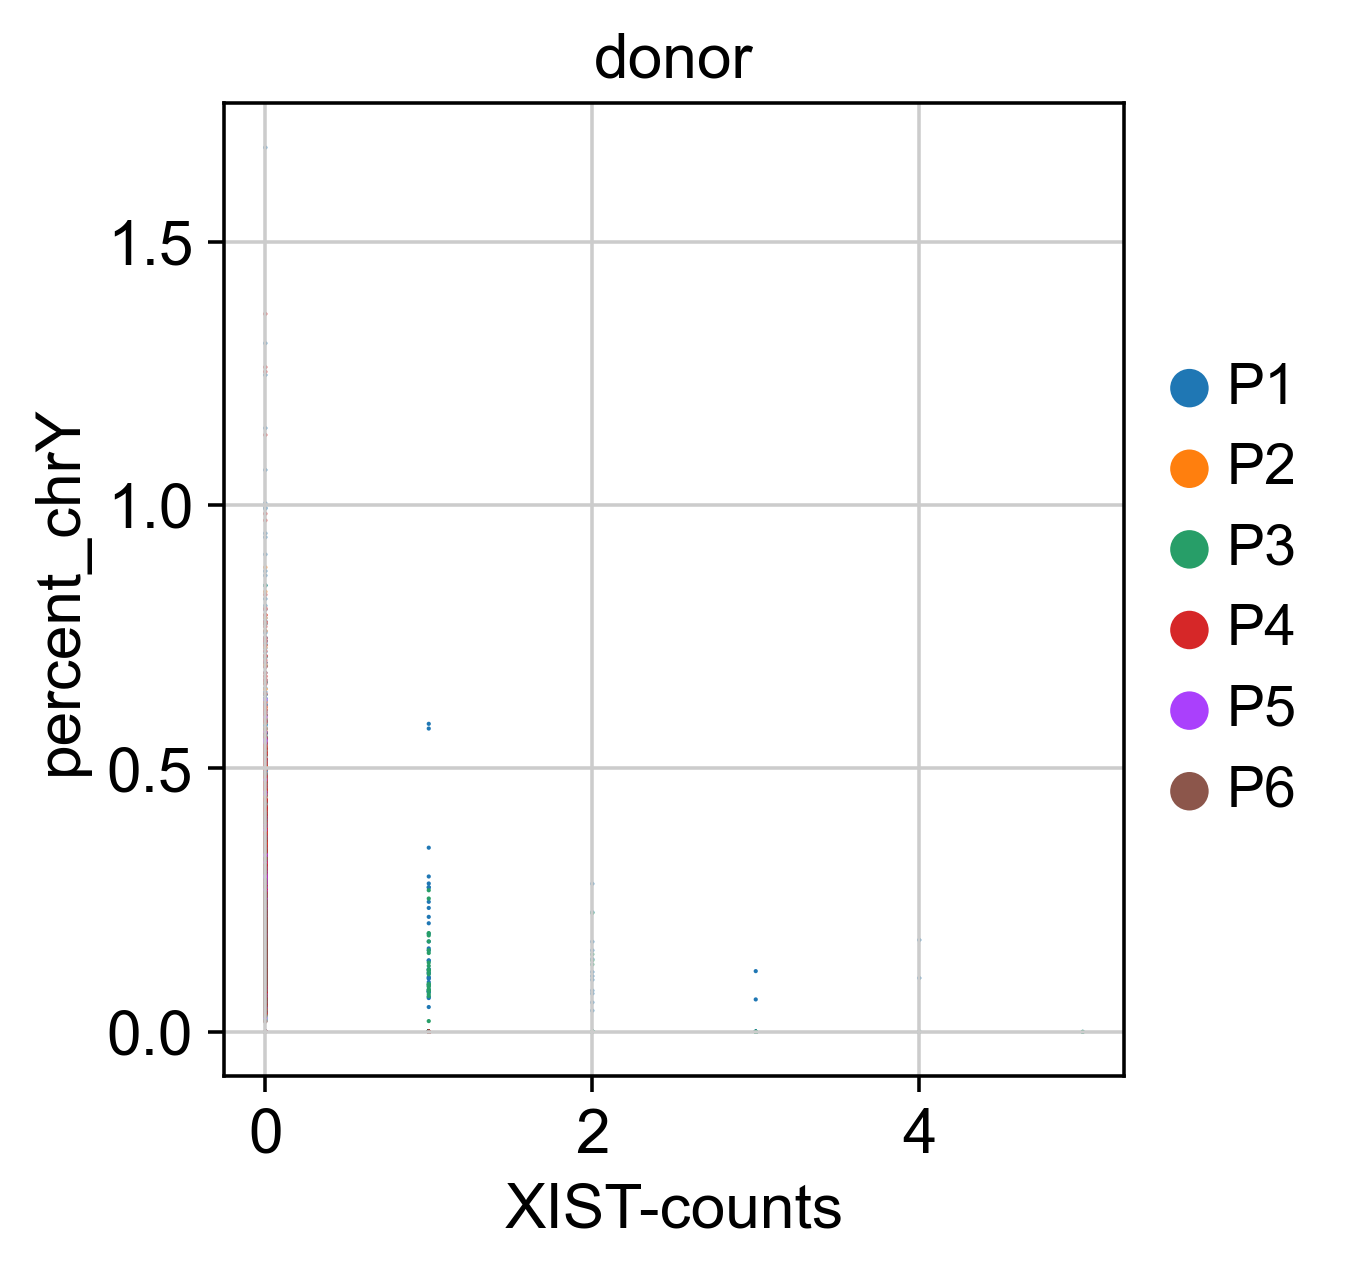

In [59]:
sample_object_new.obs["XIST-counts"] = sample_object_new.X[:,sample_object_new.var_names.str.match('XIST')].toarray()

sc.pl.scatter(sample_object_new, x = 'XIST-counts', y = 'percent_chrY', color = "donor")

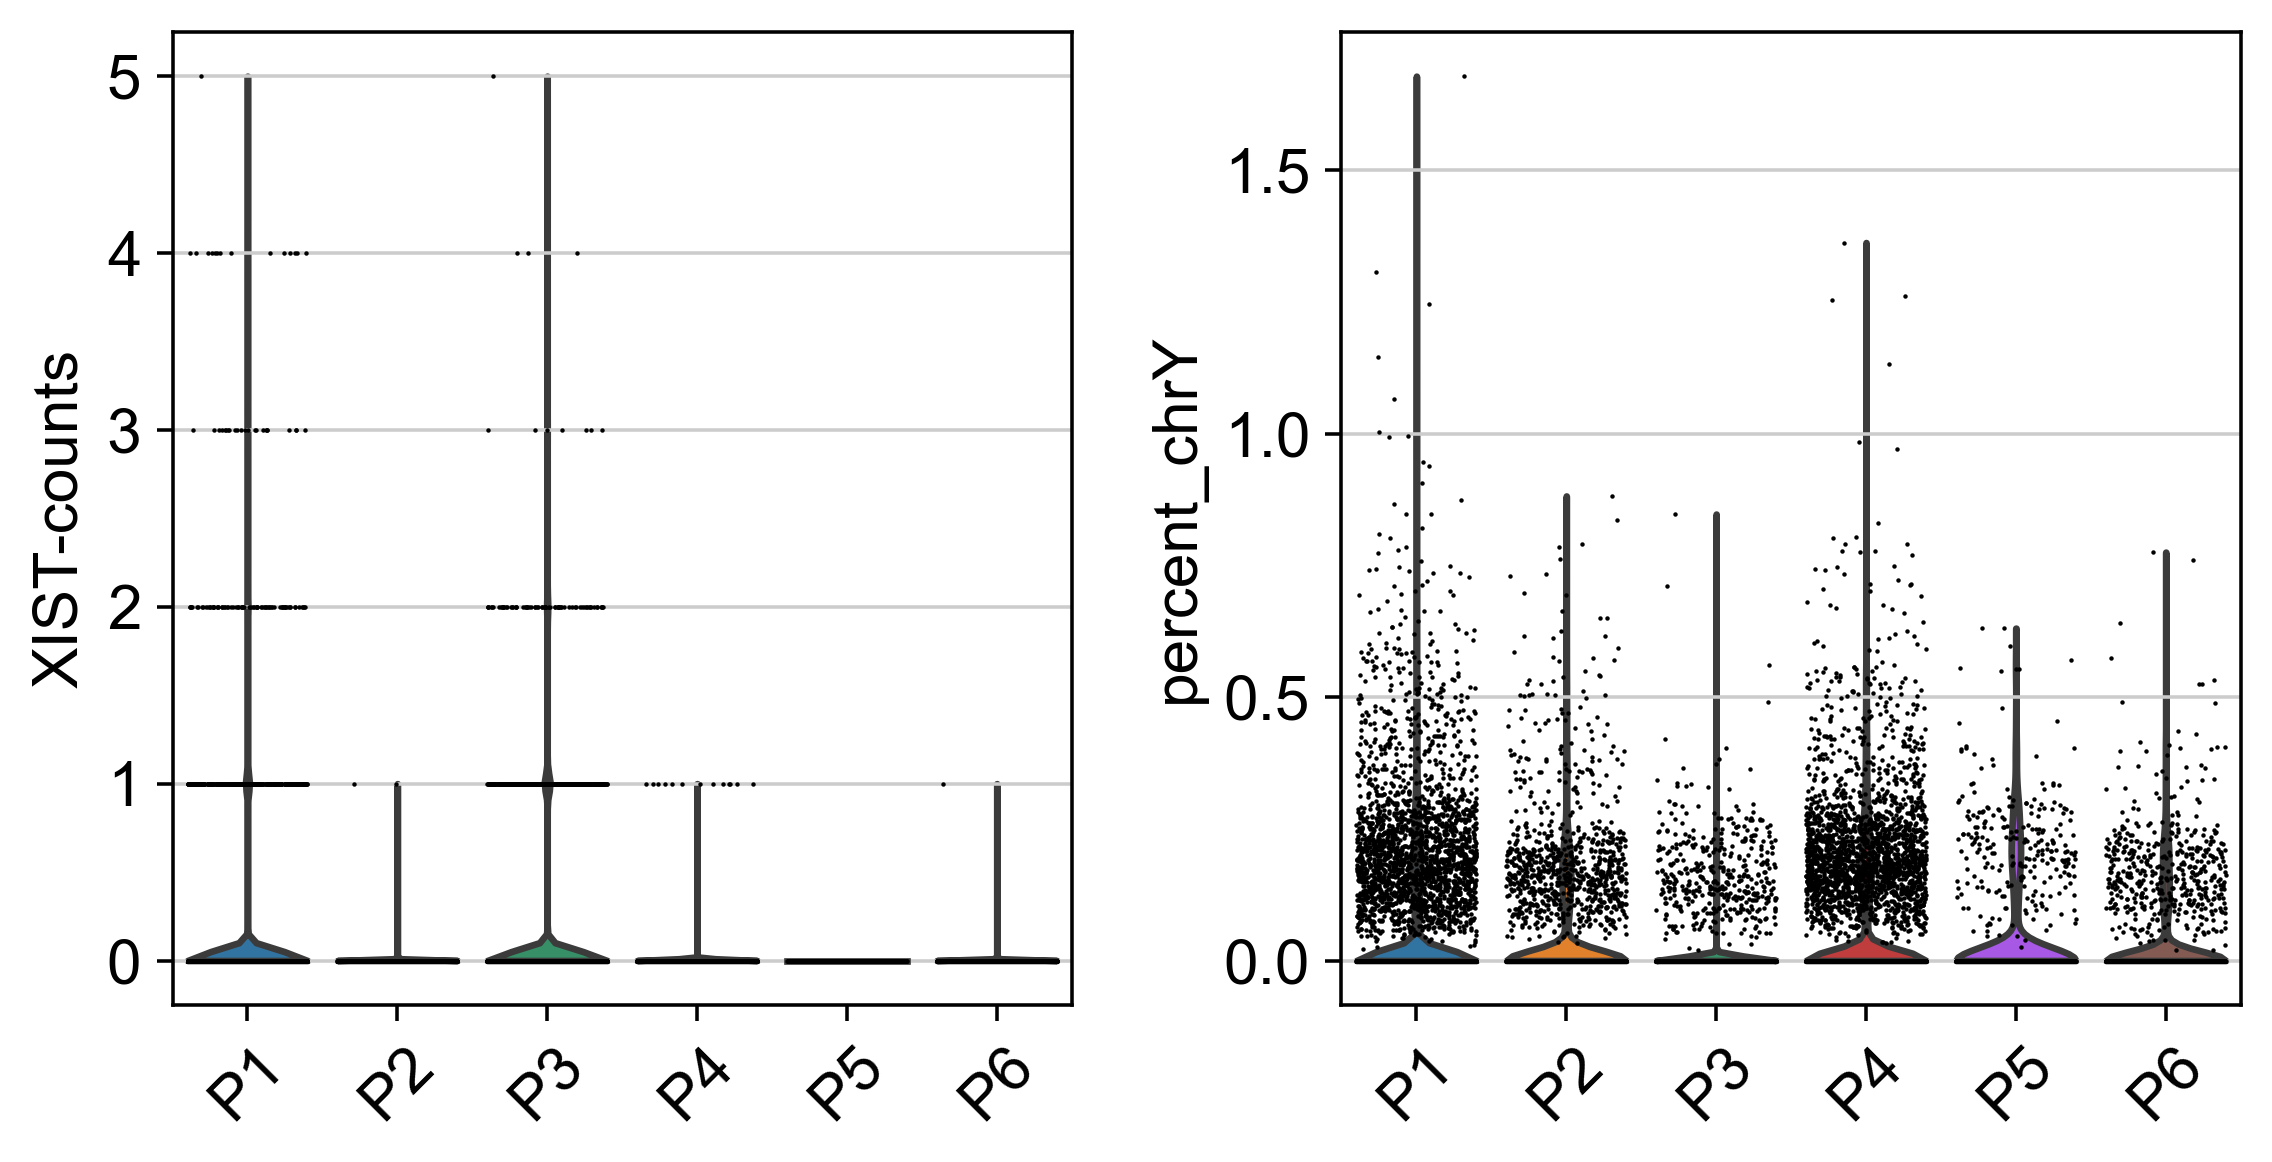

In [60]:
sc.pl.violin(sample_object_new, ["XIST-counts", "percent_chrY"], jitter = 0.4, groupby = 'donor', rotation = 45)

### Calculate cell cycle scores

In [61]:
!if [ ! -f /Users/mairi.mcclean/cell_cycle_gene.txt ]; then curl -o /Users/mairi.mcclean/cell_cycle_gene.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt; fi


In [62]:
cell_cycle_genes = [x.strip() for x in open('/Users/mairi.mcclean/cell_cycle_gene.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in sample_object_new.var_names]
print(len(cell_cycle_genes))

97
94


- Create basic `anndata` for score calculation

In [63]:
# Why was the data log-transformed at this step?

adata_log = anndata.AnnData(X = sample_object_new.X,  var = sample_object.var, obs = sample_object_new.obs)
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['ENSG00000288934', 'IGKV3-15', 'IGKV3-20', 'ENSG00000286848', 'ENSG00000248223', 'CD74', 'ENSG00000230521', 'ENSG00000227766', 'ENSG00000271581', 'ACTB', 'ENSG00000243004', 'ENSG00000272256', 'ENSG00000203396', 'VIM-AS1', 'HBB', 'BEST1', 'MALAT1', 'ENSG00000257764', 'BTG1-DT', 'HELLPAR', 'TPT1', 'ENSG00000273149', 'IGHA1', 'IGHG1', 'IGHG3', 'ENO3', 'ENSG00000266865', 'JSRP1', 'ENSG00000267598', 'BCAS4', 'PRAMENP', 'IGLV1-40', 'IGLV3-19', 'MIF-AS1', 'XACT', 'ENSG00000225840']
    finished (0:00:00)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    557 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    817 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


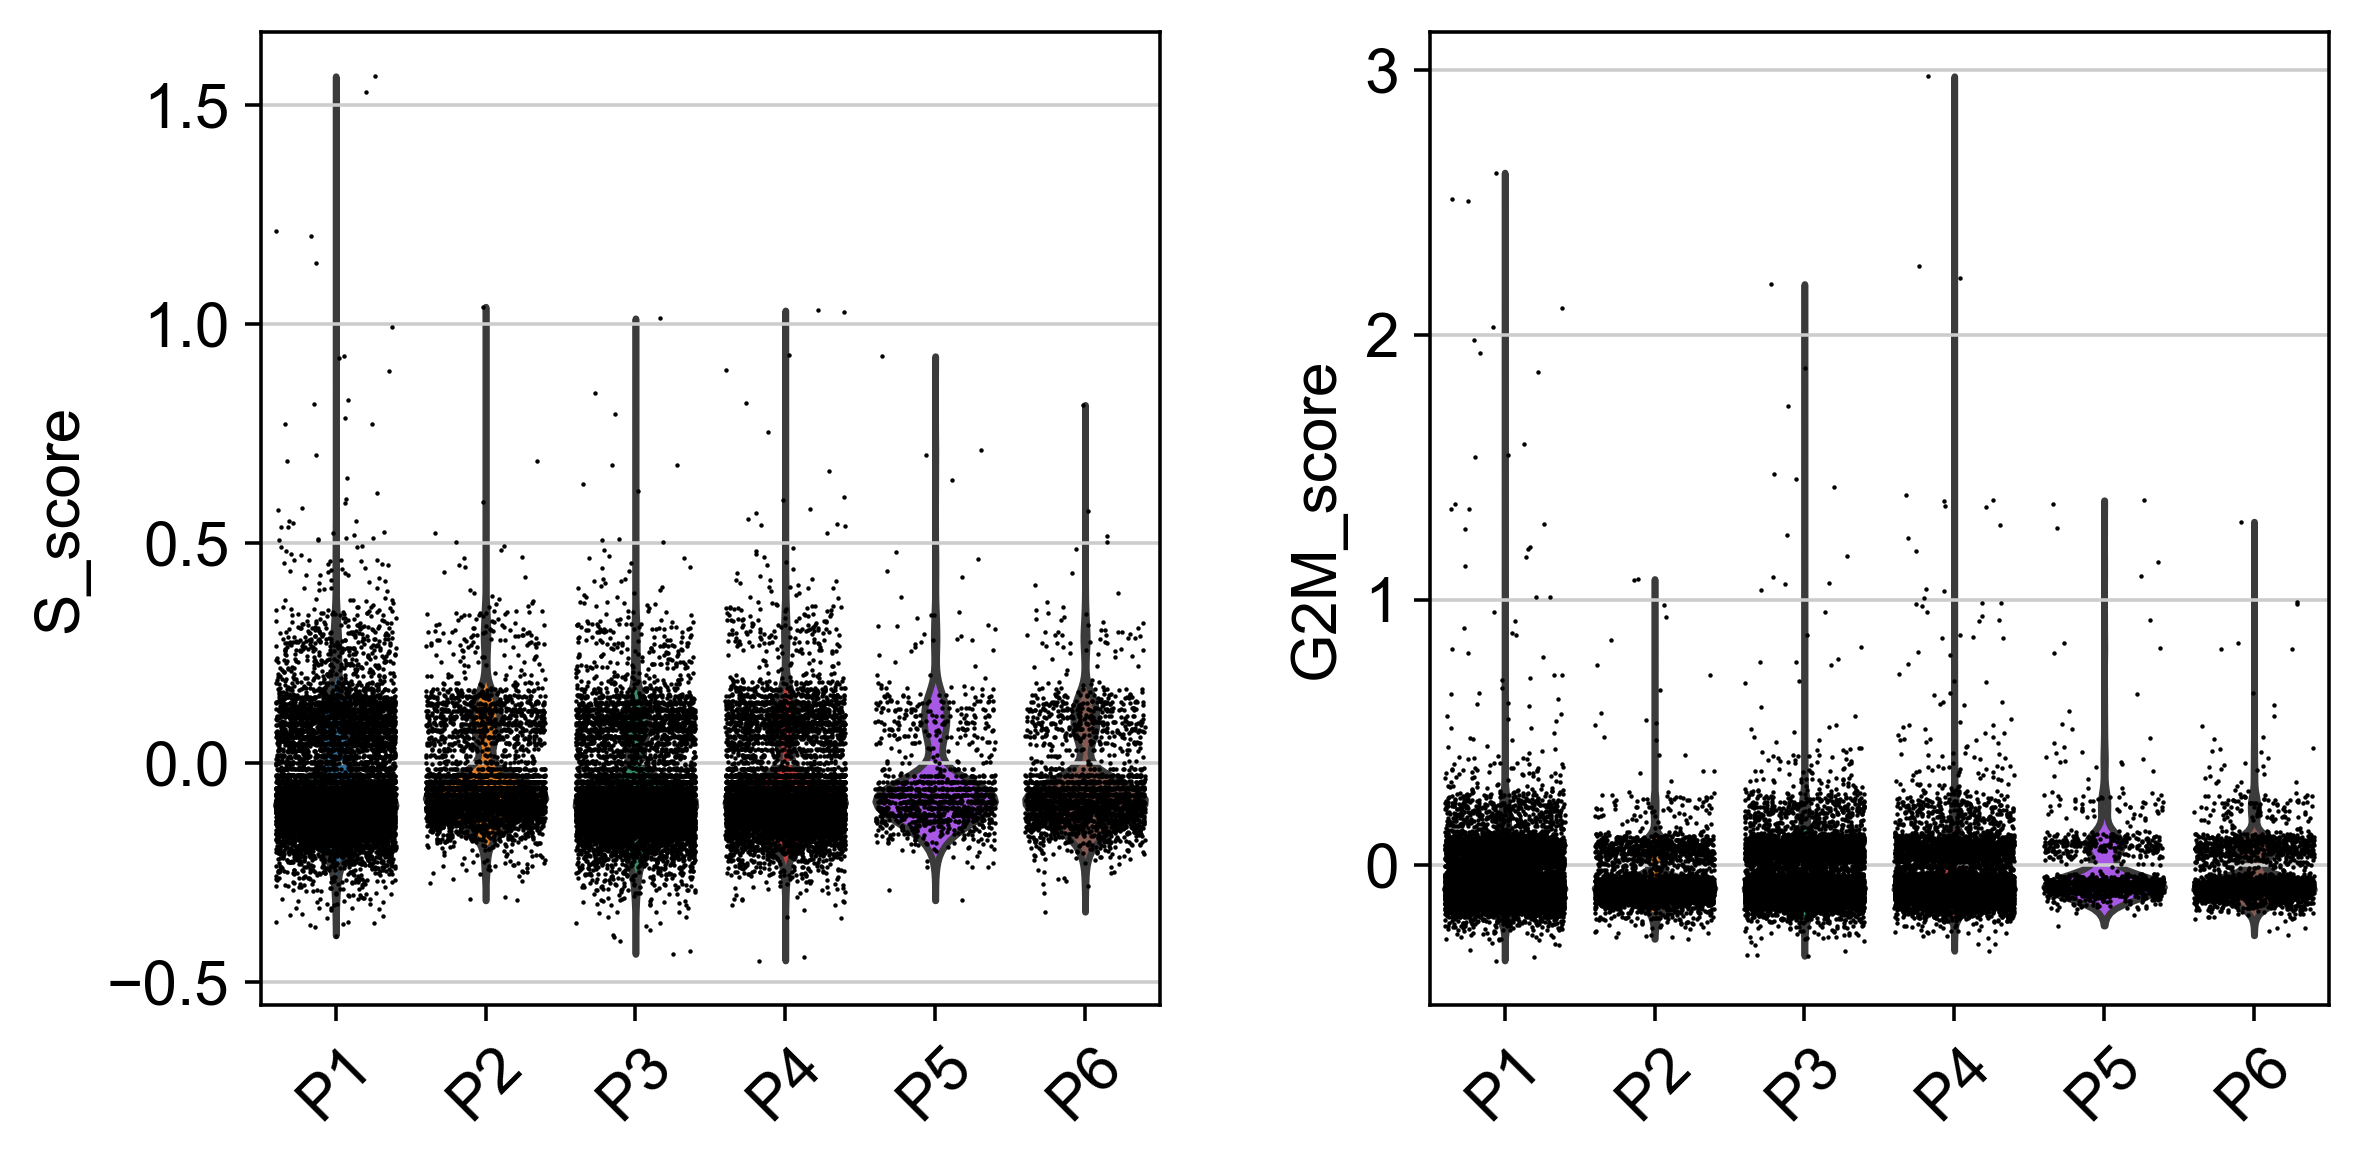

In [64]:
sc.tl.score_genes_cell_cycle(adata_log, s_genes = s_genes, g2m_genes = g2m_genes)
sc.pl.violin(adata_log, ['S_score', 'G2M_score'],
             jitter = 0.4, groupby = 'donor', rotation = 45)

In [65]:
sample_object_new.obs['S_score'] = adata_log.obs['S_score']
sample_object_new.obs['G2M_score'] = adata_log.obs['G2M_score']
sample_object_new

AnnData object with n_obs × n_vars = 33871 × 35390
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'data_type', 'centre', 'version', 'object', 'protocol', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'
    uns: 'donor_colors', 'tissue_colors'

### Predict doublets

Preprocessing...


/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.48
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 11.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.9%
Elapsed time: 41.8 seconds


111

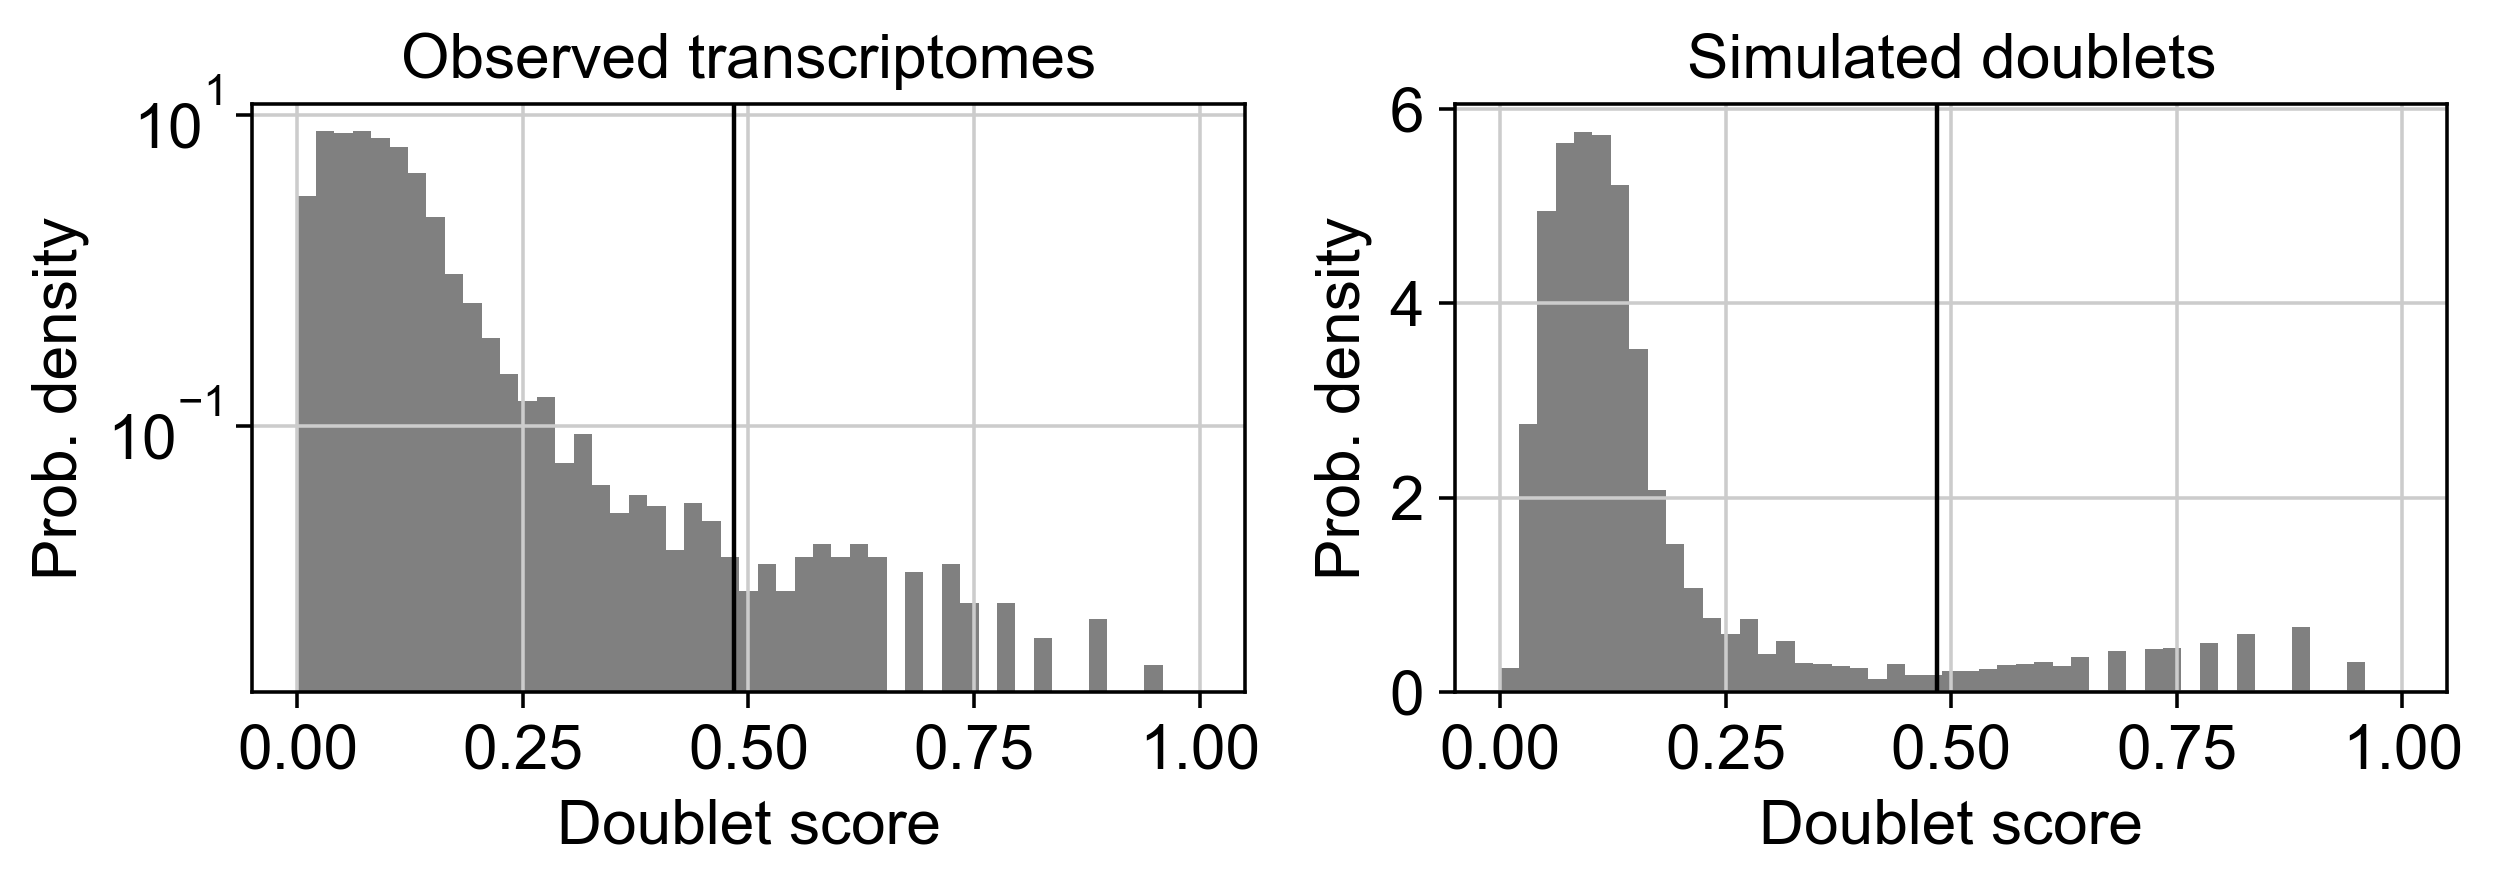

In [66]:
scrub = scr.Scrublet(sample_object_new.X)
sample_object_new.obs['doublet_scores'], sample_object_new.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(sample_object_new.obs['predicted_doublets'])

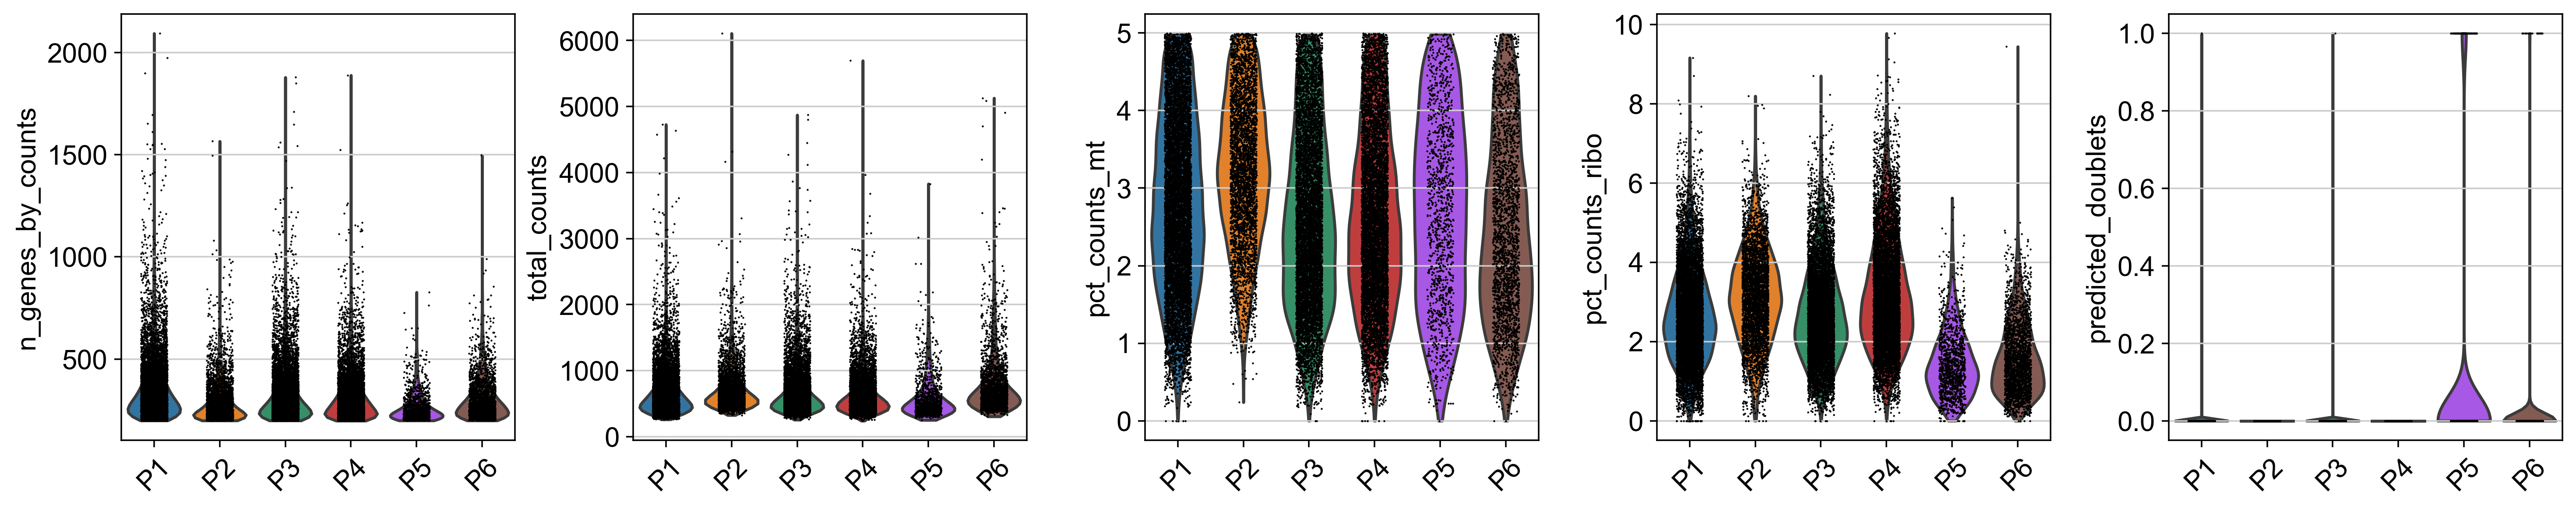

In [67]:
#check if our predicted doublets also have more detected genes in general
sc.pl.violin(sample_object_new, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'predicted_doublets'],
             jitter = 0.2, groupby = 'donor', rotation = 45)

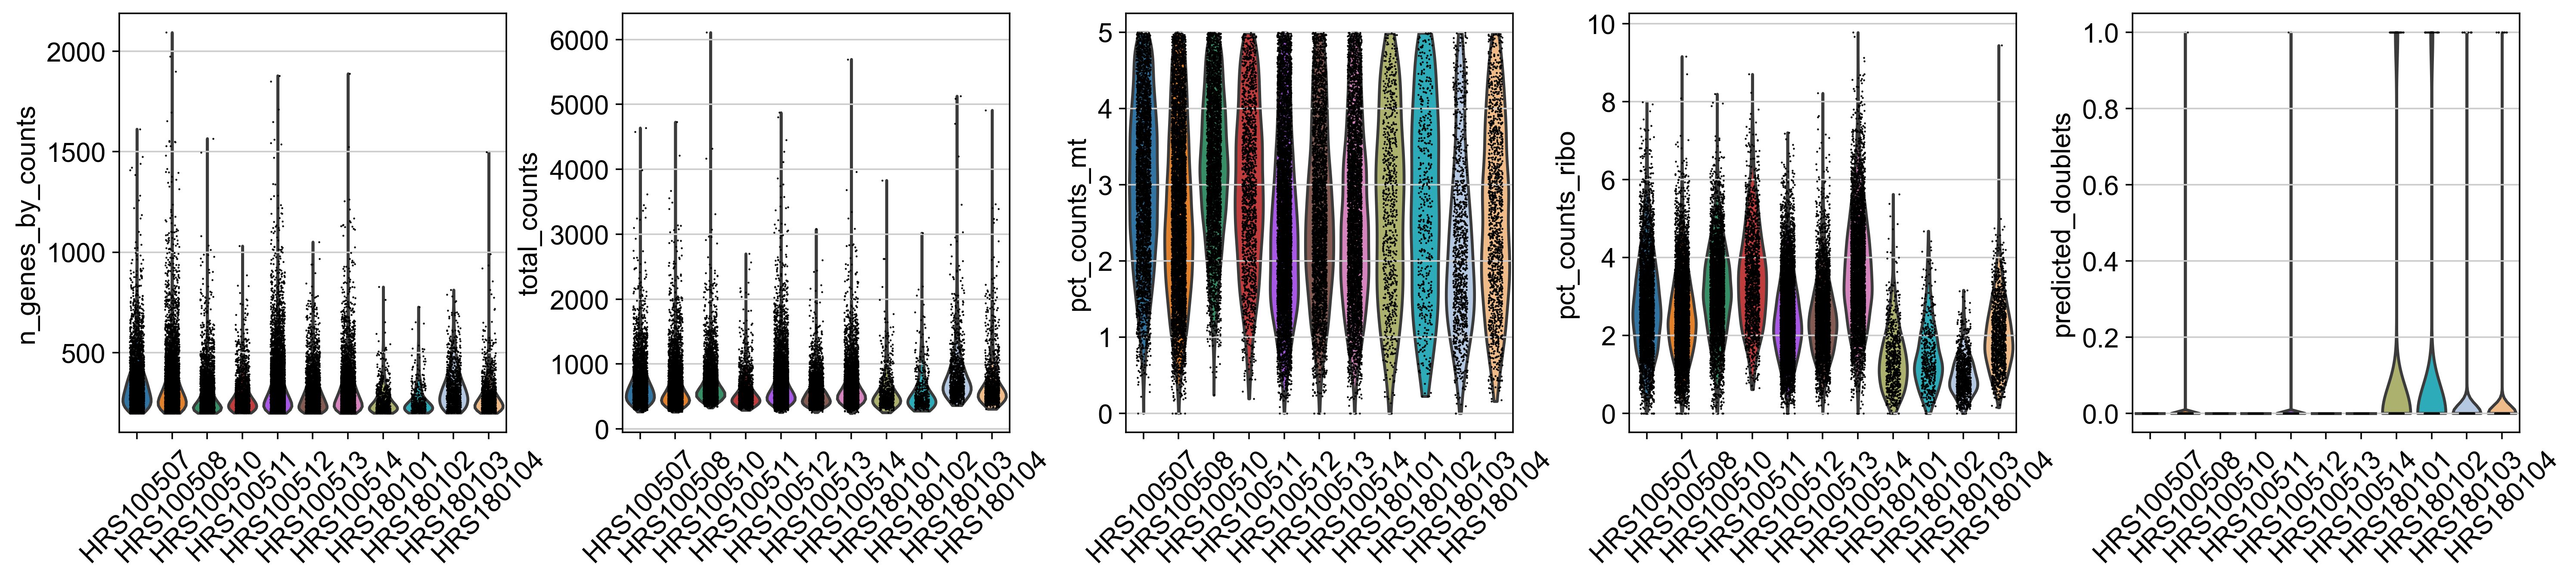

In [68]:
sc.pl.violin(sample_object_new, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'predicted_doublets'],
             jitter = 0.2, groupby = 'sample', rotation = 45)

### Prepare counts for individual slots

Preparation for data normalization

>> not QC?

In [69]:
sample_object_new.raw = sample_object_new.copy()
sample_object_new.layers['counts'] = sample_object_new.X.copy()
sample_object_new.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(sample_object_new, inplace = False)["X"]
)
sample_object_new

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 33871 × 35390
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'data_type', 'centre', 'version', 'object', 'protocol', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'doublet_scores', 'predicted_doublets'
    var: 'gene_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'
    uns: 'donor_colors', 'tissue_colors', 'sample_colors'
    layers: 'counts', 'sqrt_norm'

### Identification of highly variable genes

#### Where should this be done? After log transformation?

In [70]:
sc.pp.highly_variable_genes(sample_object_new, min_mean=0.0125, max_mean=3, min_disp=0.5)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


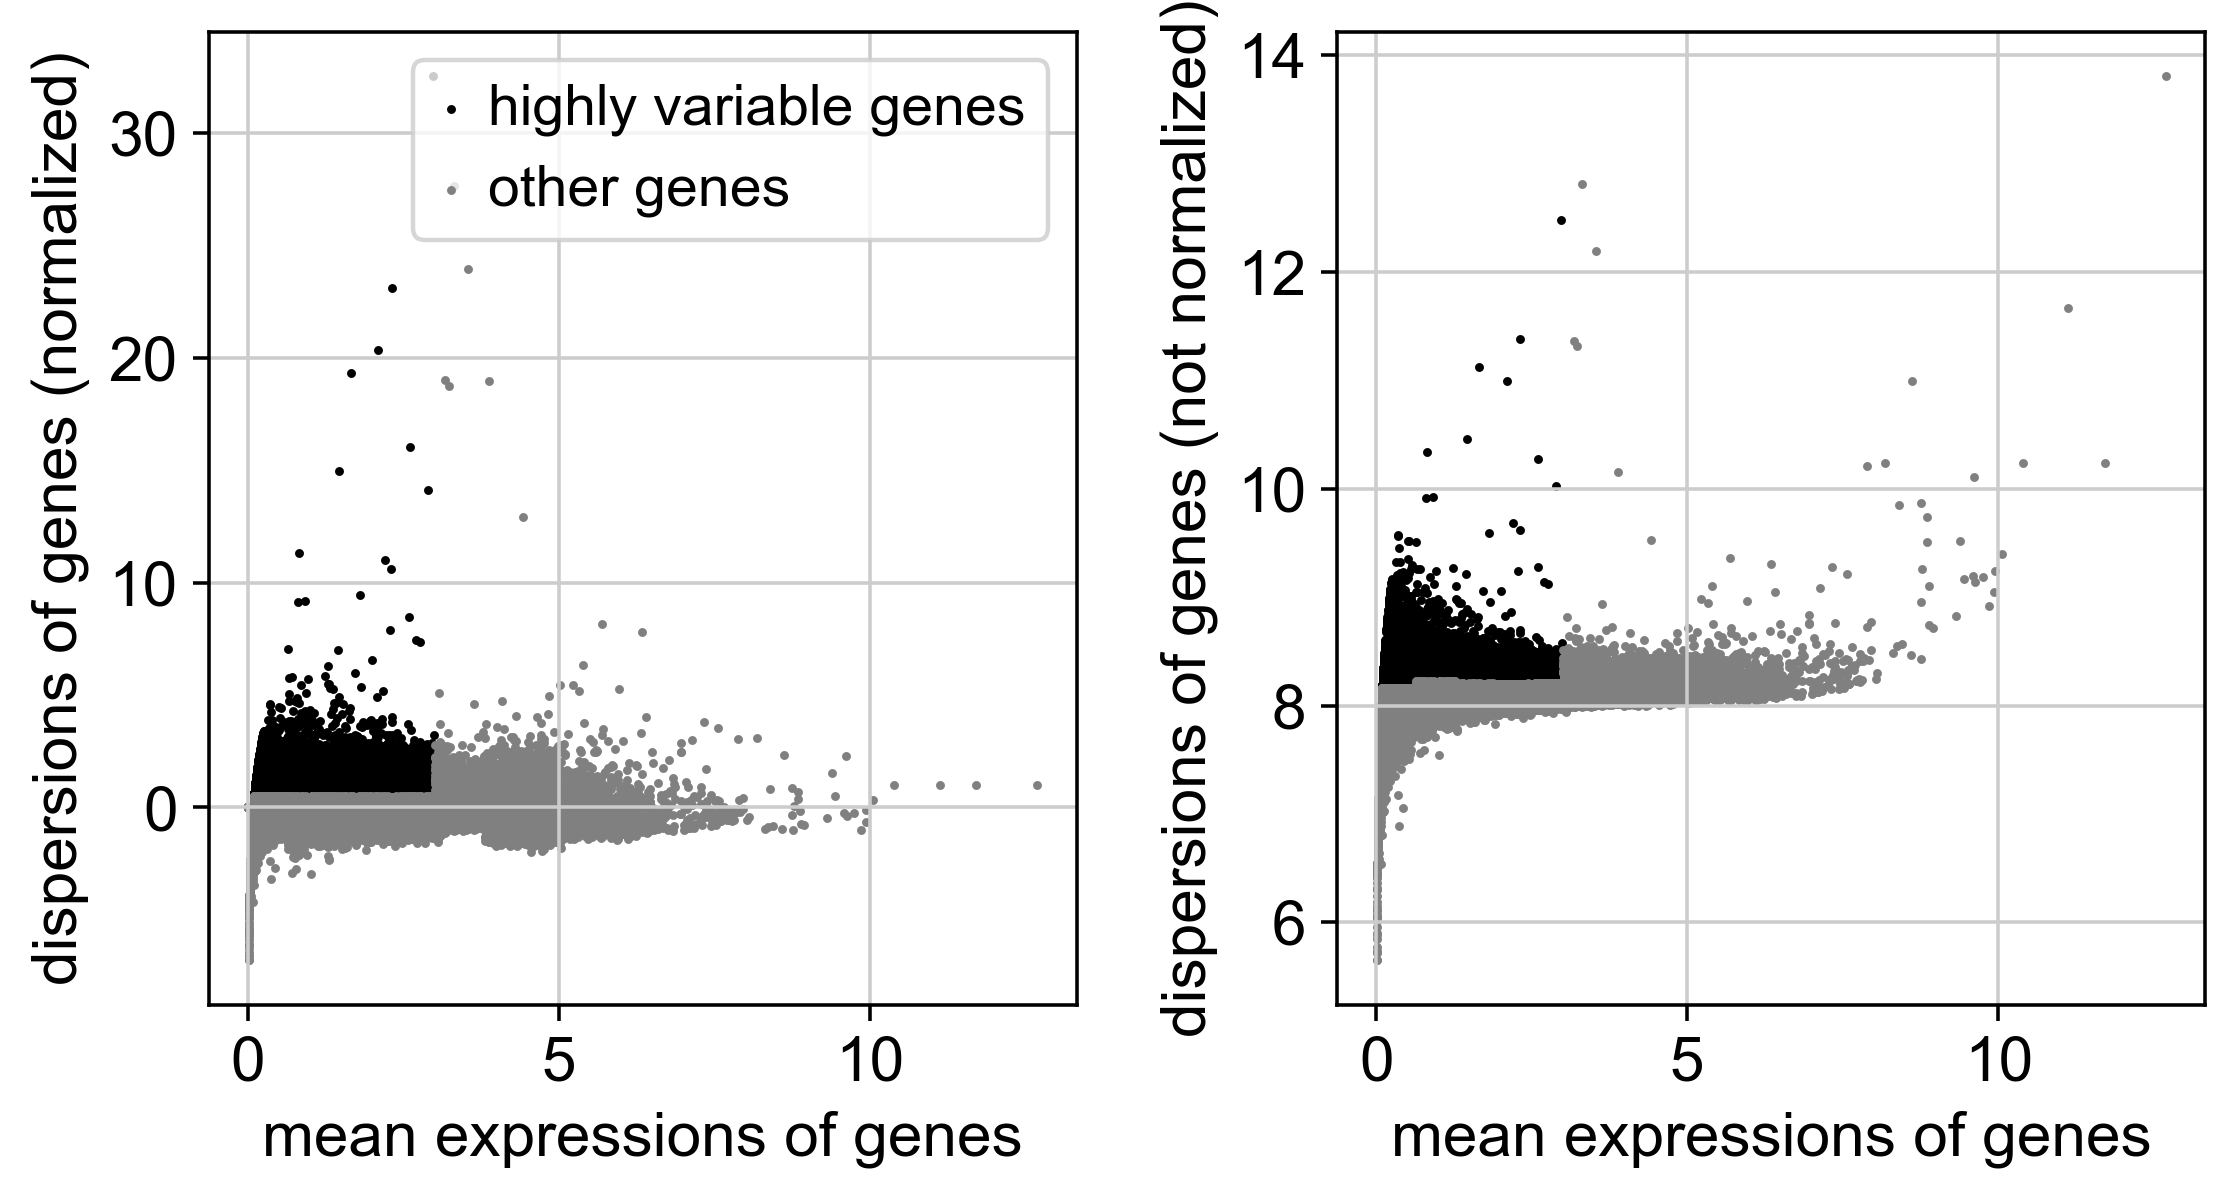

In [71]:
sc.pl.highly_variable_genes(sample_object_new)


### Export object

In [72]:
sample_object.write('/Users/mairi.mcclean/github/data/tb_pbmc_datasets/CaiY2022_PBMC_TB_QCed_pre-process_mm221117.h5ad')
